# Object Detection [Classification + Localization]

## 1 : Importing Libraries

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

## 2 : Visualization Utilities

In [6]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

In [7]:
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=3, display_str_list=()):
    image_pil = PIL.Image.fromarray(np.uint8(image * 255))
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=3, display_str_list=()):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError("Input must be of size [N,4]")
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(
            image,
            boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3],
            color=color[i] if color else "red",
            thickness=thickness,
            display_str_list=display_str_list[i] if display_str_list else None
        )


def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color="red", thickness=4, display_str_list=None,
                                use_normalized_coordinates=True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size

    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)

    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=thickness, fill=color)



In [8]:

def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    batch_train_dataset = training_dataset.unbatch().batch(N)

    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
        for training_digits, (training_labels, training_bboxes) in training_dataset:
            training_digits =training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break
    validation_labels = np.argmax(validation_labels, axis = 1)
    training_labels = np.argmax(training_labels, axis = 1)
    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)




In [9]:
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
def create_digits_from_local_fonts(n):
    font_labels = []
    im = PIL.Image.new("LA", (25 * n, 75), color=(0, 255))
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, "DejaVuSansMono-Oblique.ttf"), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, "STIXGeneral.ttf"), 25)
    d = PIL.ImageDraw.Draw(im)
    for i in range(n):
        font_labels.append(i % 10)
        d.text((7 + i * 25, 0 if i < 10 else -4), str(i % 10), fill=(255, 255), font=font1 if i < 20 else font2)
    font_digits = np.array(im.getdata(), np.float32)[:, 0] / 255.0
    font_digits = font_digits.reshape(75, 25 * n)
    font_digits = np.stack(np.split(font_digits, n, axis=1), axis=0)
    return font_digits, font_labels

In [10]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    n = 10
    indexes = np.random.choice(len(predictions), size=n)
    print("digits shape " , digits.shape)
    n_digits = digits[indexes].reshape(n, 75, 75)
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]
    n_iou = iou[indexes] if len(iou) > 0 else []
    n_pred_bboxes = pred_bboxes[indexes] if len(pred_bboxes) > 0 else np.array([])
    n_bboxes = bboxes[indexes] if len(bboxes) > 0 else np.array([])

    fig = plt.figure(figsize=(20, 4))
    plt.suptitle(title)
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        bboxes_to_plot = []
        if len(n_pred_bboxes) > i:
            bboxes_to_plot.append(n_pred_bboxes[i])
        if len(n_bboxes) > i:
            bboxes_to_plot.append(n_bboxes[i])

        im_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i],
                                                         boxes=np.asarray(bboxes_to_plot),
                                                         color=["red", "green"],
                                                         display_str_list=["Pred", "True"])
        plt.imshow(im_to_draw)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(n_predictions[i])
        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color("red")
        if len(iou) > i:
            color = "red" if n_iou[i][0] < 0.5 else "black"
            ax.text(0.2, -0.3, f"IoU {n_iou[i][0]:.2f}", color=color, transform=ax.transAxes)


In [11]:
def plot_metrics(metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color="blue" , label = metric_name)
    plt.plot(history.history["val_" + metric_name], color="green" , label = "val_" + metric_name)

## 3 : Loading And Preprocessing The Dataset

In [12]:
strategy = tf.distribute.get_strategy()
BATCH_SIZE = 64 * strategy.num_replicas_in_sync


In [13]:
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    image = tf.reshape(image, (28, 28, 1))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32) / 255.0
    xmax = (tf.cast(xmin, tf.float32) + 28) / 75.0
    ymax = (tf.cast(ymin, tf.float32) + 28) / 75.0
    xmin = tf.cast(xmin, tf.float32) / 75.0
    ymin = tf.cast(ymin, tf.float32) / 75.0
    return image, (tf.one_hot(label, 10), [ymin, xmin, ymax, xmax])



In [14]:
def get_training_dataset():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True).repeat()
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset


In [15]:
def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat()
    return dataset

In [16]:
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(
    training_dataset, validation_dataset, 10)

# Visualize Data

digits shape  (64, 75, 75, 1)


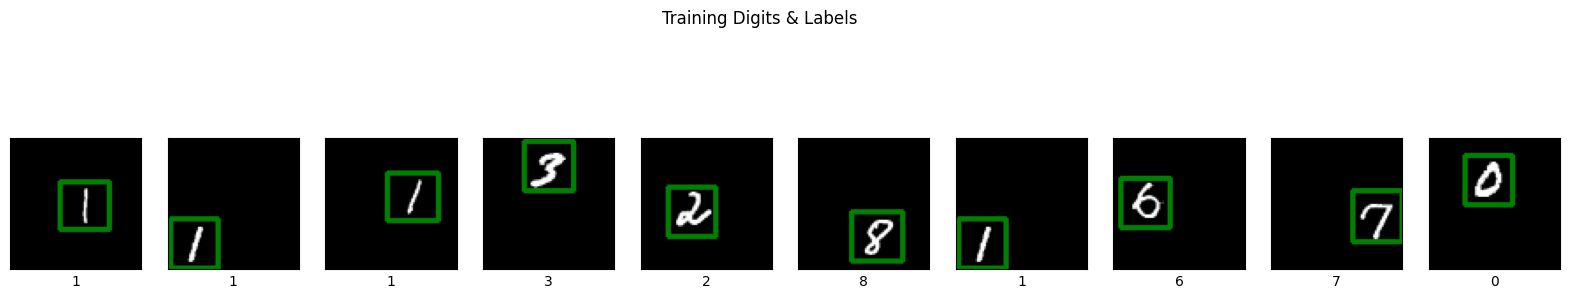

In [17]:
display_digits_with_boxes(training_digits, training_labels, training_labels, training_bboxes,
                          training_bboxes, np.array([]), "Training Digits & Labels")

digits shape  (64, 75, 75, 1)


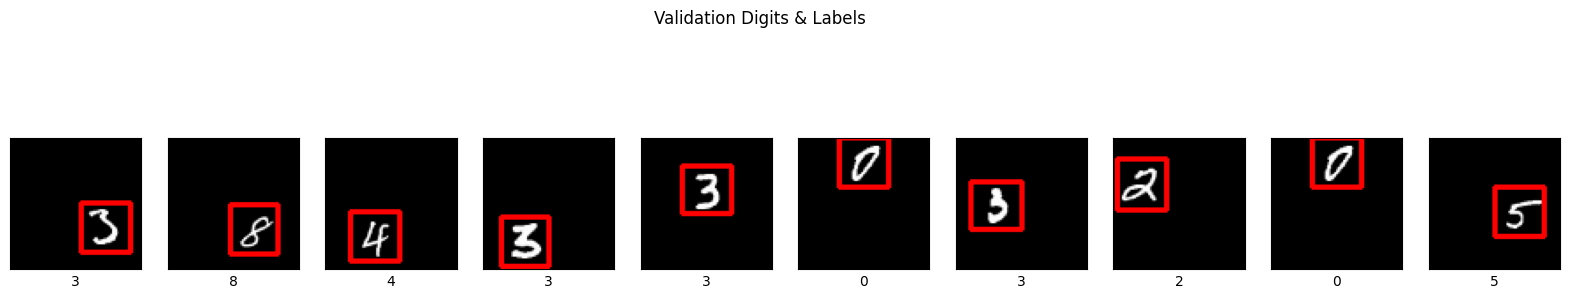

In [18]:
display_digits_with_boxes(validation_digits , validation_labels , 
                          validation_labels , np.array([]) , validation_bboxes,
                          np.array([]) , "Validation Digits & Labels")

## 4 : Define The Network

In [19]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16 , activation = "relu" , kernel_size=3, input_shape=(75,75,1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(32 , activation="relu", kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64 , activation="relu", kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    return x
    

In [20]:
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="relu")(x)

    return x

In [21]:
def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation = "softmax", name="classification")(inputs)
    return classification_output
    

In [22]:
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = "bounding_box")(inputs)
    return bounding_box_regression_output

In [23]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs , outputs = [classification_output , bounding_box_output])

    return model

In [24]:
def define_and_compile_model(inputs):
    model = final_model(inputs)

    model.compile(optimizer = "adam" , loss = {"classification" : "categorical_crossentropy",
                                                "bounding_box" : "mse"},
                  metrics = {"classification" :"accuracy", "bounding_box" : "mse"})

    return model
                

In [25]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75,75,1))
    model = define_and_compile_model(inputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 73, 73, 16)           160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 36, 36, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 32)           4640      ['average_pooling2d[0][0]'

## 5 : Train And Validaate The Model

In [27]:
EPOCHS = 20
steps_per_epoch = 60000//BATCH_SIZE
validation_steps = 1

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, validation_data= validation_dataset,
                    validation_steps=1, epochs=EPOCHS)
loss , classification_loss , bounding_box_loss , classification_acc , bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("\n----------------------------------------------------\n")
print("validation accuracy :", classification_acc)
print("\n----------------------------------------------------\n")


Epoch 1/20



937/937 [==============================] - 18s 18ms/step - loss: 1.0339 - classification_loss: 1.0190 - bounding_box_loss: 0.0149 - classification_accuracy: 0.6417 - bounding_box_mse: 0.0149 - val_loss: 0.3491 - val_classification_loss: 0.3400 - val_bounding_box_loss: 0.0091 - val_classification_accuracy: 0.9062 - val_bounding_box_mse: 0.0091
Epoch 2/20
937/937 [==============================] - 17s 18ms/step - loss: 0.2884 - classification_loss: 0.2820 - bounding_box_loss: 0.0064 - classification_accuracy: 0.9171 - bounding_box_mse: 0.0064 - val_loss: 0.2873 - val_classification_loss: 0.2826 - val_bounding_box_loss: 0.0047 - val_classification_accuracy: 0.9062 - val_bounding_box_mse: 0.0047
Epoch 3/20
937/937 [==============================] - 17s 18ms/step - loss: 0.2056 - classification_loss: 0.2020 - bounding_box_loss: 0.0036 - classification_accuracy: 0.9395 - bounding_box_mse: 0.0036 - val_loss: 0.2211 - val_classification_loss: 0.2181 - val_bounding_box_loss: 0.0030 - val_classi

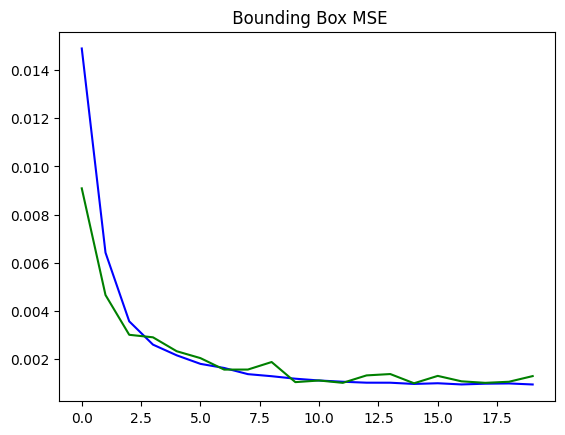

In [28]:
plot_metrics("bounding_box_mse" , " Bounding Box MSE")

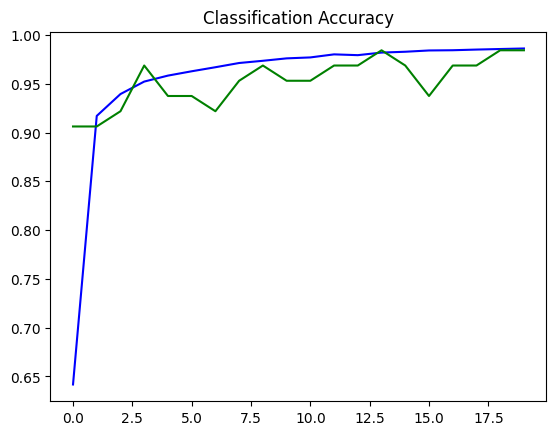

In [29]:
plot_metrics("classification_accuracy" , "Classification Accuracy")

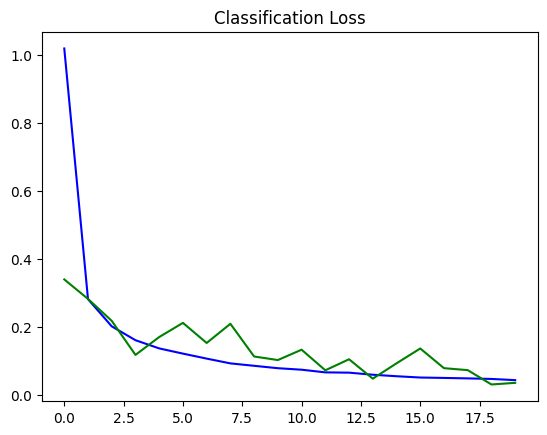

In [30]:
plot_metrics("classification_loss" , "Classification Loss")

In [35]:
def intersection_over_union(pred_box, true_box):
    xmin_pred , ymin_pred , xmax_pred , ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true , ymin_true , xmax_true , ymax_true = np.split(true_box,4 , axis=1)


    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred , xmin_true)
    xmax_overlap = np.minimum(xmax_pred , xmax_true)
    ymin_overlap = np.maximum(ymin_pred , ymin_true)
    ymax_overlap = np.minimum(ymax_pred , ymax_true)

    pred_box_area = (xmax_pred - xmin_pred)*(ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true)*(ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0) * np.maximum((ymax_overlap - ymin_overlap),0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    return iou

1/1 [==============================] - 0s 19ms/step
digits shape  (64, 75, 75, 1)


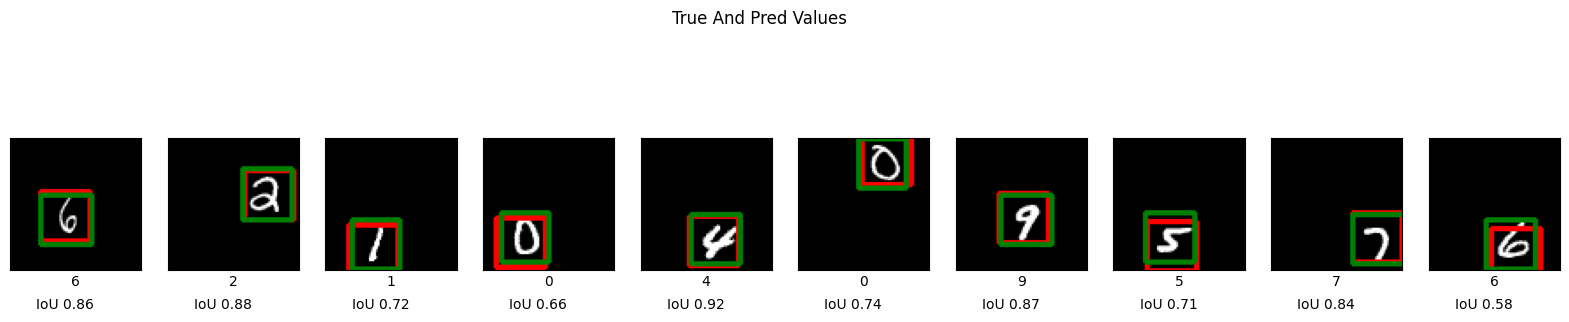

In [37]:
prediction = model.predict(validation_digits , batch_size = 64)

predicted_labels = np.argmax(prediction[0], axis = 1)

prediction_bboxes = prediction[1]

iou = intersection_over_union(prediction_bboxes, validation_bboxes)

iou_threshold = 0.6

display_digits_with_boxes(validation_digits , predicted_labels , validation_labels,
                          prediction_bboxes , validation_bboxes , iou , "True And Pred Values")